<a href="https://colab.research.google.com/github/RomersonMonteiro/Arquivos-DNC/blob/master/Mini_Projeto_Walmart_Romerson_Monteiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`````MINI PROJETO WALMART`````





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns

import zipfile as zip
import requests
import io

import scipy.stats as stats
from shapely.geometry import Point, Polygon
from datetime import datetime






In [3]:
df = pd.read_csv("/content/Walmart.csv")

# **Etapa 01**

In [4]:
df.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

**Análise inicial dos dados**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
df.describe().style.background_gradient(cmap = 'YlGnBu')

In [7]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [8]:
df.shape

(6435, 8)

In [9]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [10]:
df[df.duplicated()]

Empty DataFrame
Columns: [Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment]
Index: []

**Análise dos outliers**

In [11]:
def find_outlier_rows(df, col, level='both'):
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

In [12]:
def count_outliers(df):
    df_numeric = df.select_dtypes(include=['int', 'float'])

    columns = df_numeric.columns

    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]
    
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        outliers_df.loc[col] = [outlier_count, outlier_percent]

    return outliers_df

In [13]:
count_outliers(df).sort_values('outlier_counts', ascending=False)

outlier_counts  outlier_percent
Unemployment           481.0             7.47
Holiday_Flag           450.0             6.99
Weekly_Sales            34.0             0.53
Temperature              3.0             0.05

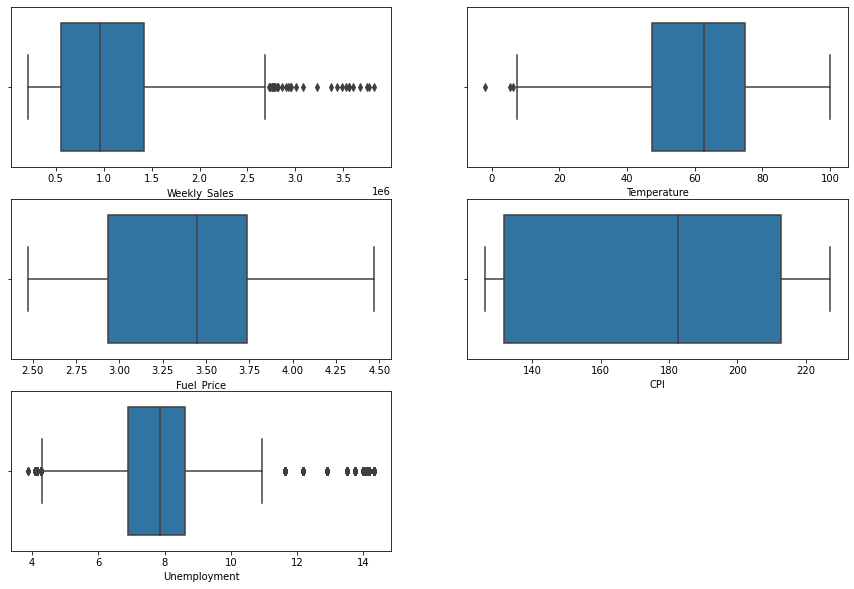

In [14]:
n = 1
cols =["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]
plt.figure(figsize=(15,10))
for i in cols:
        if n<=5:
            plt.subplot(3,2,n);
            n+=1
            sns.boxplot(x = df[i])
            plt.xlabel(i)

**Removendo os outliers**

In [15]:
l = ["Weekly_Sales","Temperature","Unemployment"]
def outlier_removal(l):
    for i in l:
        Q1  = df[i].quantile(0.25)
        Q3  = df[i].quantile(0.75)
        IQR = Q3-Q1
        Uper = Q3+1.5*IQR
        lower = Q1-1.5*IQR
        df[i]  = np.where(df[i]>Uper,Uper,(np.where(df[i]<lower,lower,df[i])))
outlier_removal(l)

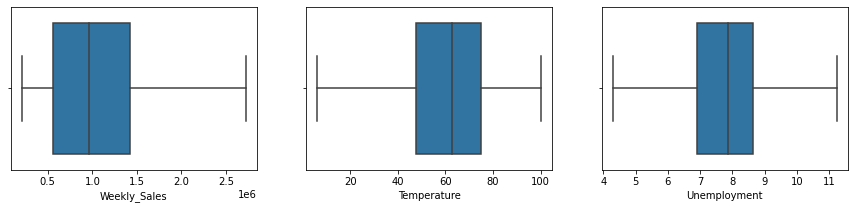

In [16]:
n = 1
cols =["Weekly_Sales","Temperature","Unemployment"]
plt.figure(figsize=(15,3))
for i in cols:
        if n<=3:
            plt.subplot(1,3,n);
            n+=1
            sns.boxplot(x = df[i])
            plt.xlabel(i)

**Ajustando datas**


In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.weekday
df['Week'] = df['Date'].dt.week
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df.drop('Date',axis=1,inplace=True)
df.head()

/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-02-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26-02-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  Day  Week  Month  Year  
0         8.106    6    17      5  2010  
1         8.106    3    48     12  2010  
2         8.106    4     7      2  2010  
3         8.106    4     8      2  2010  
4         8.106    0    18      5  2010

In [18]:
for i in df.columns:
    print(f'{i}: {df[i].nunique()}')

Store: 45
Weekly_Sales: 6402
Holiday_Flag: 2
Temperature: 3526
Fuel_Price: 892
CPI: 2145
Unemployment: 335
Day: 7
Week: 52
Month: 12
Year: 3


## PERGUNTA 1: QUAL O PREÇO MÉDIO DE VENDA SEMANAL POR LOJA?



In [19]:
df.groupby('Store')['Weekly_Sales'].mean()

Store
1     1.555264e+06
2     1.917222e+06
3     4.027044e+05
4     2.079423e+06
5     3.180118e+05
6     1.564678e+06
7     5.706173e+05
8     9.087495e+05
9     5.439806e+05
10    1.883082e+06
11    1.356383e+06
12    1.009002e+06
13    1.989683e+06
14    2.007056e+06
15    6.233125e+05
16    5.192477e+05
17    8.935814e+05
18    1.084718e+06
19    1.444999e+06
20    2.091373e+06
21    7.560691e+05
22    1.028501e+06
23    1.389767e+06
24    1.356755e+06
25    7.067215e+05
26    1.002912e+06
27    1.772584e+06
28    1.323522e+06
29    5.394514e+05
30    4.385796e+05
31    1.395901e+06
32    1.166568e+06
33    2.598617e+05
34    9.667816e+05
35    9.197250e+05
36    3.735120e+05
37    5.189003e+05
38    3.857317e+05
39    1.450668e+06
40    9.641280e+05
41    1.268125e+06
42    5.564039e+05
43    6.333247e+05
44    3.027489e+05
45    7.859814e+05
Name: Weekly_Sales, dtype: float64

##Análises gráficas

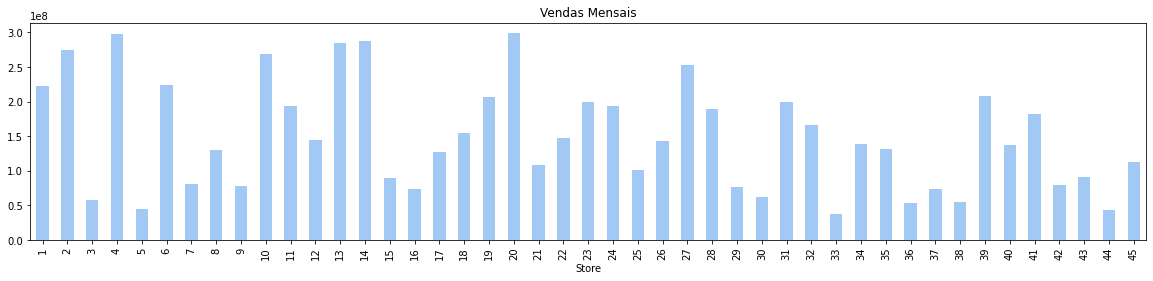

In [20]:
sns.set_palette('pastel')
plt.figure(figsize=(20,4))
vendas_por_loja = df.groupby('Store')['Weekly_Sales'].sum()
vendas_por_loja.plot(kind='bar')
plt.title('Vendas Mensais')
plt.show()

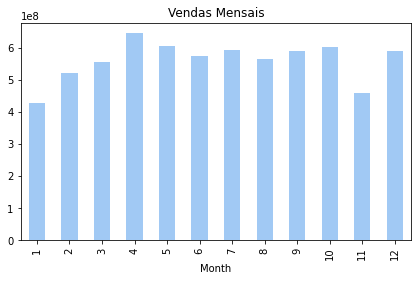

In [21]:
plt.figure(figsize=(7,4))

df.groupby('Month')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Vendas Mensais')

plt.show()

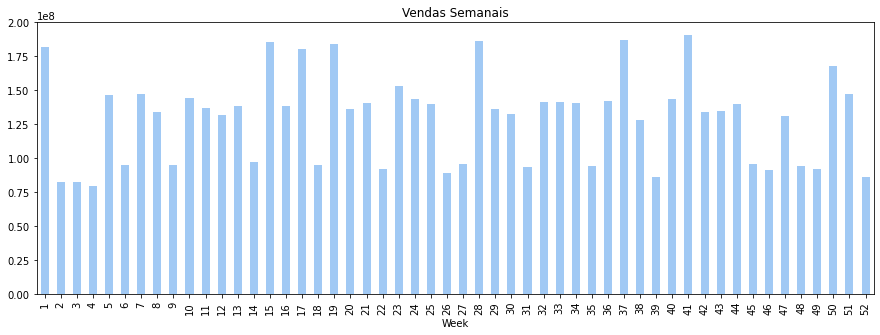

In [22]:
plt.figure(figsize=(15,5))

df.groupby(['Week'])['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Vendas Semanais')

plt.show()

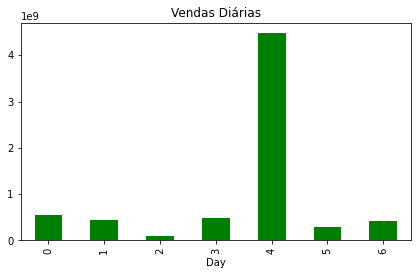

In [23]:
plt.figure(figsize=(7,4))

df.groupby(['Day'])['Weekly_Sales'].sum().plot(kind='bar',color='Green')
plt.title('Vendas Diárias')

plt.show()

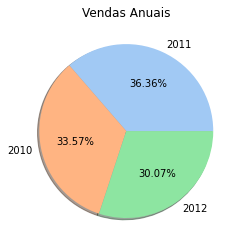

In [24]:
sns.set_palette('pastel')
plt.pie(df['Year'].value_counts().values,labels =df['Year'].value_counts().index,
       autopct='%1.2f%%',shadow=True)
plt.title('Vendas Anuais')
plt.show()  

## PERGUNTA 2: QUAL O ATRIBUTO TEM MAIOR CORRELAÇÃO POSITIVA OU NEGATIVA COM O NÚMERO DE VENDAS ( E FAÇA SENTIDO )?

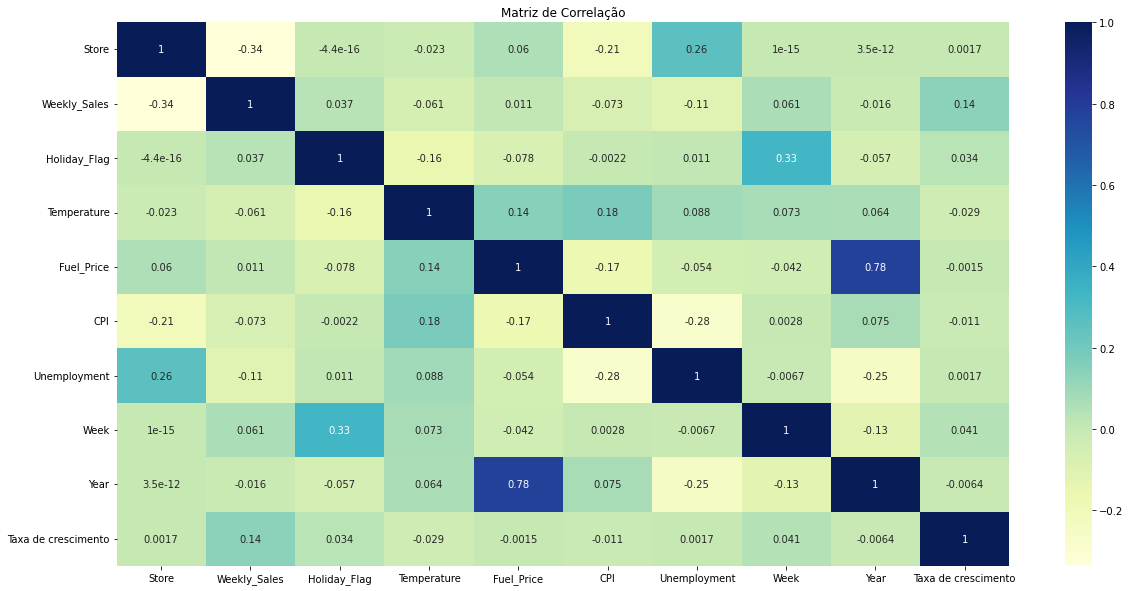

In [60]:
plt.figure(figsize = (20,10))
sns.heatmap(df2.corr(),annot=True,cmap ="YlGnBu")
plt.title('Matriz de Correlação')
plt.show()

````O atributo com maior relação é o Fuel_Price.````

## PERGUNTA 3: DA LOJA COM MAIOR VENDA ACUMULADA, QUANTAS SEMANAS ELA ULTRPASSOU A MÉDIA DO PERÍODO?

In [25]:
df_lojas= vendas_por_loja.sort_values(ascending=False)
TOP = df_lojas.index[0]
vendas_medias = df['Weekly_Sales'].mean()
acima_media = (df.loc[(df['Store'] == TOP) & (df['Weekly_Sales'] > vendas_medias)]
                    .groupby('Store')['Weekly_Sales'].count())
print(f"A loja com a maior venda acumulada ({TOP}) ultrapassou a média do período em {acima_media.values[0]} semanas.")

A loja com a maior venda acumulada (20) ultrapassou a média do período em 143 semanas.


````A loja com a maior venda acumulada (20) ultrapassou a média do período em 143 semanas.````


In [26]:
df_top_store = df

df_top_store['Acima_da_Media'] = df_top_store.apply(lambda row: 'Sim' if row['Weekly_Sales'] > vendas_medias else 'Não', axis=1)


In [27]:
contagem = df_top_store.groupby(['Store', 'Year', 'Acima_da_Media']).size().reset_index(name='Contagem')

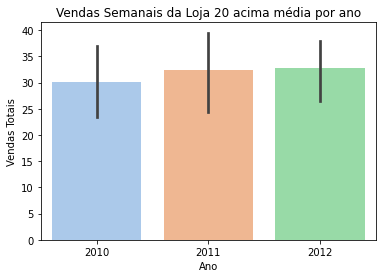

In [28]:
sns.barplot(data=contagem.query("Acima_da_Media == 'Sim'"), x='Year', y='Contagem')
plt.xlabel('Ano')
plt.ylabel('Vendas Totais')
plt.title('Vendas Semanais da Loja 20 acima média por ano')
plt.show()

**Contagem da quantidade de feriados e quantidade de dias normais**




In [29]:
df.Holiday_Flag.value_counts()

0    5985
1     450
Name: Holiday_Flag, dtype: int64

Vendas Anuais

In [30]:
df_Holiday_Flag = df[df.Holiday_Flag == 1]

In [31]:
df_Holiday_Flag.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
1       1    1641957.44             1        38.51       2.548  211.242170   
31      1    1507460.69             1        78.69       2.565  211.495190   
42      1    1955624.11             1        64.52       2.735  211.748433   
47      1    1367320.01             1        48.43       2.943  211.404932   
53      1    1649614.93             1        36.39       3.022  212.936705   

    Unemployment  Day  Week  Month  Year Acima_da_Media  
1          8.106    3    48     12  2010            Sim  
31         7.787    5    40     10  2010            Sim  
42         7.838    4    47     11  2010            Sim  
47         7.838    4    52     12  2010            Sim  
53         7.742    2    44     11  2011            Sim

In [32]:
df_normal_day = df[df.Holiday_Flag == 0]

In [33]:
df_normal_day

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0         1    1643690.90             0        42.31       2.572  211.096358   
2         1    1611968.17             0        39.93       2.514  211.289143   
3         1    1409727.59             0        46.63       2.561  211.319643   
4         1    1554806.68             0        46.50       2.625  211.350143   
5         1    1439541.59             0        57.79       2.667  211.380643   
...     ...           ...           ...          ...         ...         ...   
6430     45     713173.95             0        64.88       3.997  192.013558   
6431     45     733455.07             0        64.89       3.985  192.170412   
6432     45     734464.36             0        54.47       4.000  192.327265   
6433     45     718125.53             0        56.47       3.969  192.330854   
6434     45     760281.43             0        58.85       3.882  192.308899   

      Unemployment  Day  Week  Month  Year Acima_da_Media  
0            8.106    6    17      5  2010            Sim  
2            8.106    4     7      2  2010            Sim  
3            8.106    4     8      2  2010            Sim  
4            8.106    0    18      5  2010            Sim  
5            8.106    4    48     12  2010            Sim  
...            ...  ...   ...    ...   ...            ...  
6430         8.684    4    39      9  2012            Não  
6431         8.667    3    19      5  2012            Não  
6432         8.667    0    50     12  2012            Não  
6433         8.667    4    42     10  2012            Não  
6434         8.667    4    43     10  2012            Não  

[5985 rows x 12 columns]

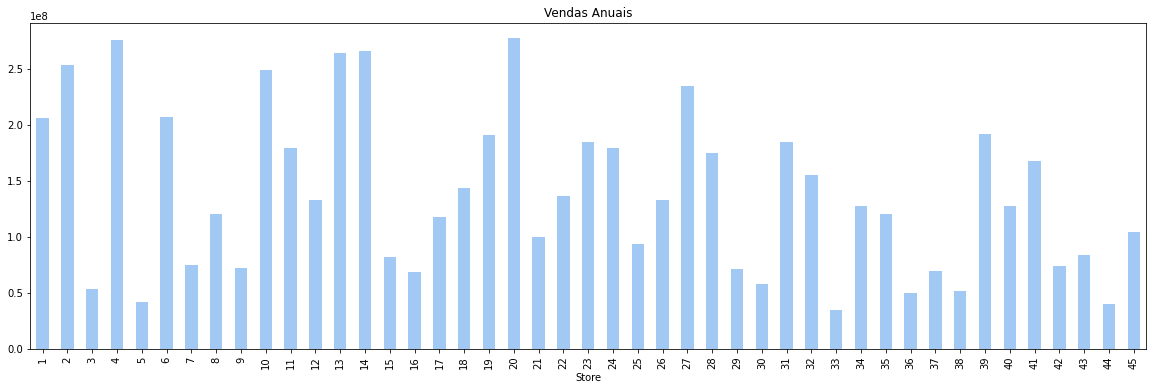

In [34]:
plt.figure(figsize=(20,6))

df_normal_day.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Vendas Anuais')

plt.show()

In [35]:
df_sales_normal_day = df_normal_day.Weekly_Sales.sum()

In [36]:
df_sales_normal_day

6220934593.202499

In [37]:
df_sales_Holiday_Flag=df_Holiday_Flag.Weekly_Sales.sum()

In [38]:
df_sales_Holiday_Flag

503828430.53249997

**Gráficos de vendas**

In [39]:
df2 = df.copy()
df2.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  Day  Week  Month  Year Acima_da_Media  
0         8.106    6    17      5  2010            Sim  
1         8.106    3    48     12  2010            Sim  
2         8.106    4     7      2  2010            Sim  
3         8.106    4     8      2  2010            Sim  
4         8.106    0    18      5  2010            Sim

In [40]:
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5: 'Friday',6:'Saturday'}
df2['Day'] = df2['Day'].map(days)
months={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'Novemenber',12:'December'}
df2['Month']= df2['Month'].map(months)
df2.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment        Day  Week     Month  Year Acima_da_Media  
0         8.106   Saturday    17       May  2010            Sim  
1         8.106  Wednesday    48  December  2010            Sim  
2         8.106   Thursday     7  February  2010            Sim  
3         8.106   Thursday     8  February  2010            Sim  
4         8.106     Sunday    18       May  2010            Sim

In [41]:
df2= df2.round(decimals=2)

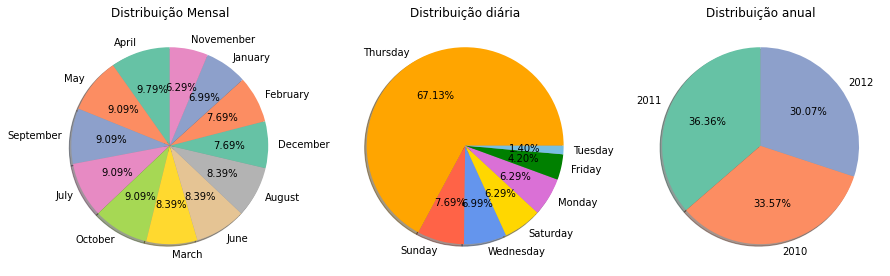

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)
plt.pie(df2['Day'].value_counts().values, labels =df2['Day'].value_counts().index,
autopct = '%1.2f%%', shadow=True,colors=["Orange",'tomato', 'cornflowerblue', 'gold', 'orchid', 'green',"#77BFE2"]) 
plt.title('Distribuição diária')
plt.grid()

plt.subplot(1, 3, 1)
plt.pie(df2['Month'].value_counts().values, labels =df2['Month'].value_counts().index,
autopct = '%1.2f%%',startangle=90, shadow=True,colors=sns.color_palette('Set2'))
plt.title('Distribuição Mensal')
plt.grid()

plt.subplot(1, 3, 3)
df3 = df2.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()
plt.pie(df2['Year'].value_counts().values, labels =df2['Year'].value_counts().index,
autopct = '%1.2f%%',startangle=90, shadow=True,colors=sns.color_palette('Set2'),labeldistance=1.1)  
plt.title('Distribuição anual')
plt.grid()


plt.show()

## PERGUNTA 4: Faça um gráfico com as vendas máximas, mínimas e médias de todas as lojas ao longo do tempo. Ressalte de alguma forma, o período de feriados mencionados acima.

<Axes: xlabel='Month', ylabel='Weekly_Sales'>

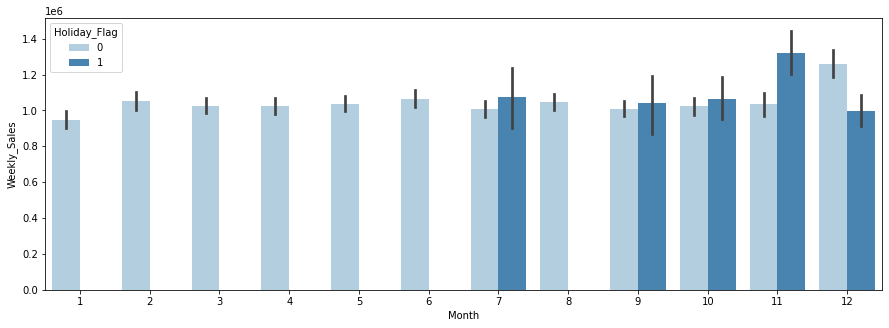

In [43]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'Month',
            y = 'Weekly_Sales',
            hue = 'Holiday_Flag',
            palette = "Blues",
            data = df)

<Figure size 1080x864 with 0 Axes>

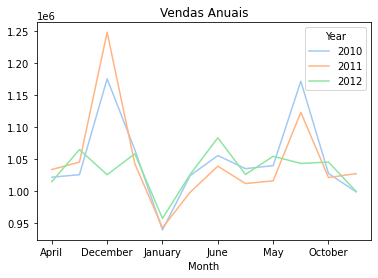

In [44]:
plt.figure(figsize=(15,12))
monthly_sales = pd.pivot_table(df2, index = "Month", columns = "Year", values = "Weekly_Sales")
monthly_sales.plot()
plt.title('Vendas Anuais')
plt.show()

In [45]:
print('Venda MÍNIMA: ',df2.groupby('Store')['Weekly_Sales'].sum().min())
print('Venda MÁXIMA: ',df2.groupby('Store')['Weekly_Sales'].sum().max())


Venda MÍNIMA:  37160221.96
Venda MÁXIMA:  299066335.24


##Analise de dados com e sem feriado

In [46]:
df10 = df2.query('Holiday_Flag == 1').groupby(['Store', 'Week']).agg({'Weekly_Sales': ['max', 'min', 'mean']})
df10_sales_Holiday_Flag=df10.Weekly_Sales.sum()
df10_sales_Holiday_Flag

max     3.545916e+08
min     3.400030e+08
mean    3.472973e+08
dtype: float64

In [47]:
df11 = df2.query('Holiday_Flag == 0').groupby(['Store', 'Week']).agg({'Weekly_Sales': ['max', 'min', 'mean']})
df11_sales_Holiday_Flag=df11.Weekly_Sales.sum()
df11_sales_Holiday_Flag

max     2.470555e+09
min     2.221577e+09
mean    2.342351e+09
dtype: float64

**Análise de correlação dos atributos**

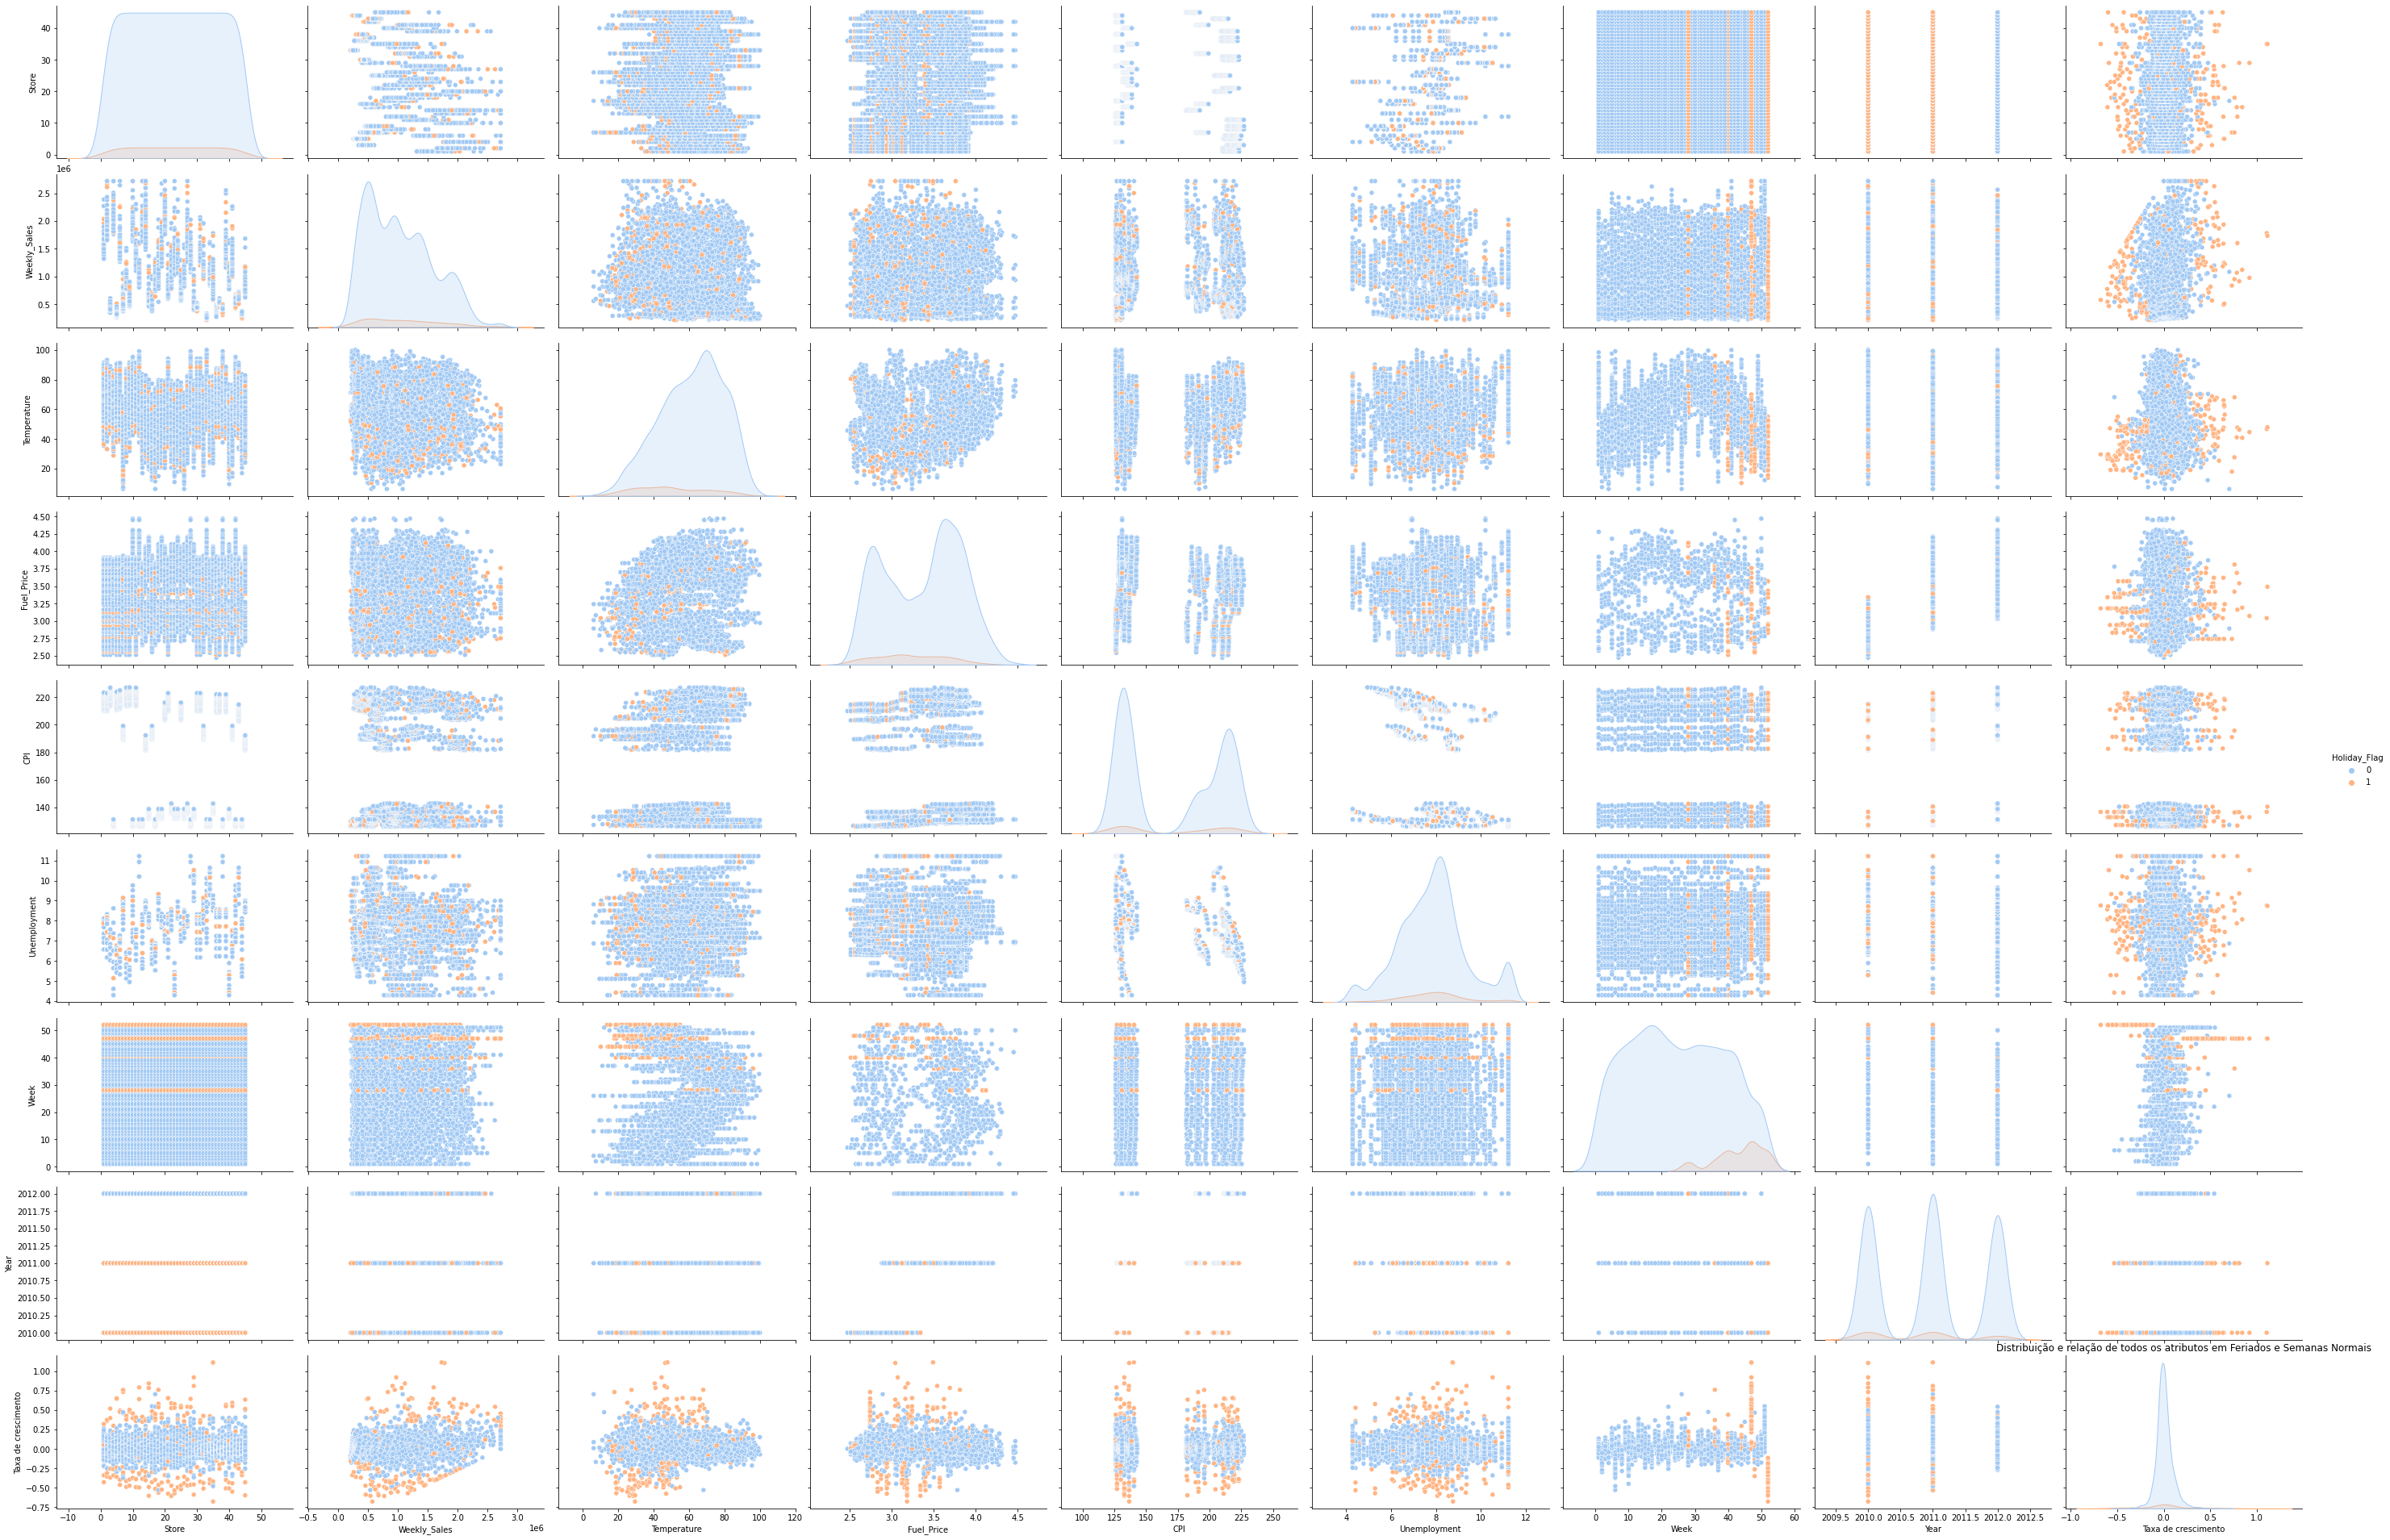

In [59]:
sns.pairplot(df2, hue="Holiday_Flag", height=3, aspect=1.5)
plt.title("Distribuição e relação de todos os atributos em Feriados e Semanas Normais");

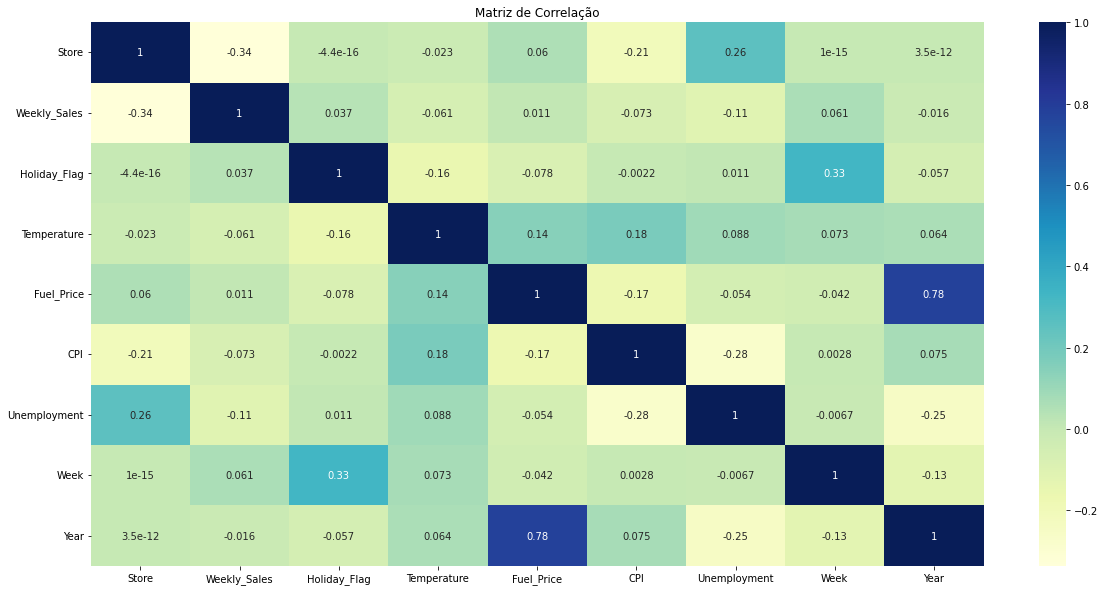

In [49]:
plt.figure(figsize = (20,10))
sns.heatmap(df2.corr(),annot=True,cmap ="YlGnBu")
plt.title('Matriz de Correlação')
plt.show()

## PERGUNTA 5: Pensando na expansão de uma das lojas, que loja você escolheria e o por que?



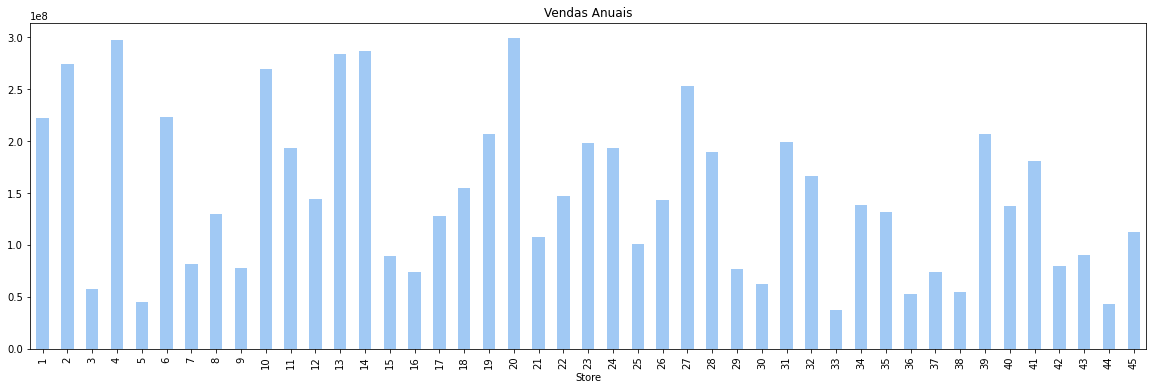

In [50]:
plt.figure(figsize=(20,6))

df2.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Vendas Anuais')

plt.show()

In [51]:
df2['Taxa de crescimento'] = df2.groupby('Store')['Weekly_Sales'].pct_change()

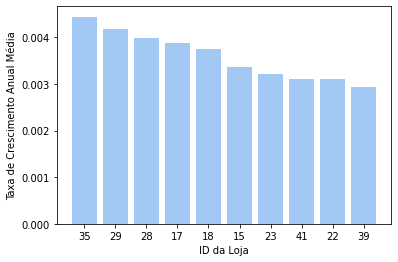

In [52]:
taxa_crescimento_media = (1 + df2.groupby('Store')['Taxa de crescimento'].agg(np.mean))**(1/3) - 1
top_10_lojas = taxa_crescimento_media.nlargest(10).index.unique()

top_10_df = df2[df2['Store'].isin(top_10_lojas)]

taxa_crescimento_medio_por_loja = top_10_df.groupby('Store')['Taxa de crescimento'].mean()

x_labels = [str(loja) for loja in top_10_lojas]

x_pos = np.arange(len(top_10_lojas))
y_values = taxa_crescimento_media.loc[top_10_lojas]
plt.bar(x_pos, y_values)
plt.xticks(x_pos, x_labels)

plt.xlabel('ID da Loja')
plt.ylabel('Taxa de Crescimento Anual Média')

plt.show()

In [53]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(df2, x="Fuel_Price", y="Weekly_Sales", size = "Weekly_Sales", color = 'Store',
                 title="Vendas Semanais por Preço de Combustível")
fig.show()

In [54]:
ranking_final=df2.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
ranking_final.reset_index()

Store  Weekly_Sales
0      20  2.990663e+08
1       4  2.973575e+08
2      14  2.870091e+08
3      13  2.845247e+08
4       2  2.741628e+08
5      10  2.692807e+08
6      27  2.534795e+08
7       6  2.237489e+08
8       1  2.224028e+08
9      39  2.074455e+08
10     19  2.066349e+08
11     31  1.996139e+08
12     23  1.987367e+08
13     24  1.940160e+08
14     11  1.939628e+08
15     28  1.892637e+08
16     41  1.813419e+08
17     32  1.668192e+08
18     18  1.551147e+08
19     22  1.470756e+08
20     12  1.442872e+08
21     26  1.434164e+08
22     34  1.382498e+08
23     40  1.378703e+08
24     35  1.315207e+08
25      8  1.299512e+08
26     17  1.277821e+08
27     45  1.123953e+08
28     21  1.081179e+08
29     25  1.010612e+08
30     43  9.056544e+07
31     15  8.913368e+07
32      7  8.159828e+07
33     42  7.956575e+07
34      9  7.778922e+07
35     29  7.714155e+07
36     16  7.425243e+07
37     37  7.420274e+07
38     30  6.271689e+07
39      3  5.758674e+07
40     38  5.515963e+07
41     36  5.341221e+07
42      5  4.547569e+07
43     44  4.329309e+07
44     33  3.716022e+07

````A loja 10 é a melhor loja para investimento pois além de ter bom comportamento geral em vendas totais (6° lugar) é a que o melhor número de vendas quando a gasolina, principal fator de redução das vendas, está em seu valor mais alto. Bastará fazer ajustes na estratégia de vendas para que a Loja 10 assuma o 1° lugar.````